# Importing the libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import cv2
import tensorflow as tf
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import AdamW, Adam
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.applications import MobileNet
from keras.applications import DenseNet169
from tensorflow.keras.metrics import Accuracy, Precision, Recall, F1Score
import time
from keras.callbacks import Callback
from concurrent.futures import ProcessPoolExecutor

In [2]:
tf.__version__

'2.15.0'

In [3]:
!nvidia-smi

Tue Mar 12 12:47:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Resizing the images to (224, 224) as required by DenseNet

## Images aren't resized

(224, 224, 3)


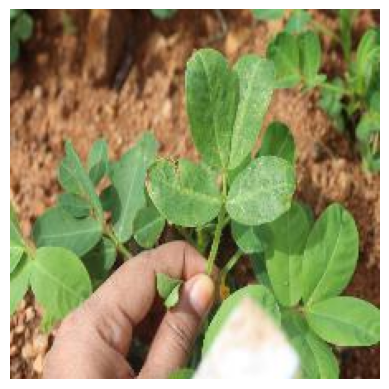

In [4]:
#img_path = '/content/drive/MyDrive/Plant-Disease-v1/Dataset/Bell_pepper leaf/Bell_pepper leaf (10).jpg'
img_path = '/kaggle/input/ground-dataset-densenet/GROUND NUT LEAVES DETECTION/Raw_Data/early_leaf_spot/IMG_0325.JPG'
img = mpimg.imread(img_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

## Resizing the images

In [ ]:
inp_dir = '/kaggle/input/ground-dataset-densenet/GROUND NUT LEAVES DETECTION/Raw_Data'

target_size = (224, 224)

print(os.listdir(inp_dir))

for folder in os.listdir(inp_dir):


  folder_path = os.path.join(inp_dir, folder)
  if os.path.isdir(folder_path):

    print(f'Processing images in the folder: {folder}')
    for filename in os.listdir(folder_path):

      if filename.endswith(('.jpg', '.jpeg', '.png')):



        #load the img
        img_path = os.path.join(folder_path, filename)
        img = mpimg.imread(img_path)

        #resizing
        resized_img = cv2.resize(img, target_size)

        #overwriting the input images with the resized images
        mpimg.imsave(img_path, resized_img)


print('Done with Resizing')

## Checking whether or not the image have been resized

(224, 224, 3)


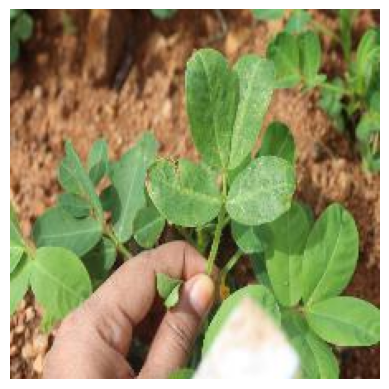

In [5]:
#img_path = '/content/drive/MyDrive/Plant-Disease-v1/Dataset/Bell_pepper leaf/Bell_pepper leaf (10).jpg'
img_path = '/kaggle/input/ground-dataset-densenet/GROUND NUT LEAVES DETECTION/Raw_Data/early_leaf_spot/IMG_0325.JPG'
img = mpimg.imread(img_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

# Converting the images to array 

In [7]:
def convert_img_to_array(image_dir):
  try:
    img = cv2.imread(image_dir)
    if img is not None:
      return img_to_array(img)
    else:
      return np.array([])

  except Exception as e:
    print(f'Error: {e}')
    return None

# Reading the images and converting them into an array

In [8]:
def process_directory(args):
    directory, temp = args
    images = []
    labels = []
    for files in os.listdir(directory):
        img_path = os.path.join(directory, files)
        images.append(convert_img_to_array(img_path))
        labels.append(binary_labels[temp])
    return images, labels

# Reading the images one by one and converting them into an array

In [9]:
#dir = '/content/drive/MyDrive/Plant-Disease-v1/Dataset'
dir = '/kaggle/input/ground-dataset-densenet/GROUND NUT LEAVES DETECTION/Raw_Data'
image_list, label_list = [], []
#all_labels = os.listdir('/content/drive/MyDrive/Plant-Disease-v1/Dataset')
all_labels = os.listdir('/kaggle/input/ground-dataset-densenet/GROUND NUT LEAVES DETECTION/Raw_Data')
# binary_labels = [0, 1]
#temp = -1

binary_labels = list(range(5))

#Reading and Converting the image into to numpy array
for temp, directory in enumerate(all_labels[:5]):
    plant_img_list = os.listdir(f'{dir}/{directory}')
    for files in plant_img_list:
        img_path = f'{dir}/{directory}/{files}'
        image_list.append(convert_img_to_array(img_path))
        label_list.append(binary_labels[temp])


In [10]:
print(all_labels)
# print(image_list[0].shape)

['healthy leaf', 'nutrition deficiency', 'early_leaf_spot', 'rust', 'late leaf spot']


## Checking the frequecny of images in each class

In [11]:
labels_count = pd.DataFrame(label_list).value_counts()
labels_count

0
0    929
2    885
4    689
1    329
3    226
Name: count, dtype: int64

# Splitting the data into train test split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size = 0.2, random_state = 67)

# Normalizing the data

In [13]:
x_train = np.array(x_train, dtype = np.float16) / 255.0
x_test = np.array(x_test, dtype = np.float16) / 255.0
x_train = x_train.reshape(-1, 224, 224, 3)
x_test = x_test.reshape(-1, 224, 224, 3)

In [14]:
print(x_test.shape)

(612, 224, 224, 3)


In [15]:
print(len(y_train))

2446


# One Hot Encoding

In [16]:
# y_train = y_train.reshape((8192, 4))
y_train = to_categorical(y_train)
# y_train = to_categorical(y_train)
# y_test = y_test.reshape((8192, 4))
y_test = to_categorical(y_test)
# y_train = y_train
# y_test = y_test

In [ ]:
print(y_train.shape)

In [ ]:
print(y_test.shape)

# Creating the model

In [21]:
IMAGE_SIZE = [224, 224]
densenet = DenseNet169(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top=False)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
for layer in densenet.layers:
    layer.trainable = False

In [23]:
x = GlobalAveragePooling2D()(densenet.output)
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=densenet.input, outputs=prediction)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,651,205 (48.26 MB)

 Trainable params: 8,325 (32.52 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

# Compiling the model

In [24]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

# Splitting the training set into train and validation set

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=67)
# x_train = np.array(x_train).reshape(-1, 224, 224, 3)
# y_train = np.array(y_train)

# Training the Model

In [26]:
epochs = 300
batch_size = 16
start_time = time.time()
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))
end_time = time.time()
total_time = end_time - start_time
print('Training time is: ', total_time)
model.save('/kaggle/working/models/groundnut_disease_model_densenet169.h5')

Epoch 1/300
  2/123 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.0469 - loss: 2.2989   

I0000 00:00:1710248892.943462     268 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710248893.037029     268 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.2268 - loss: 1.7316

W0000 00:00:1710248918.160274     270 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710248932.620878     270 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 104s 494ms/step - accuracy: 0.2276 - loss: 1.7300 - val_accuracy: 0.4347 - val_loss: 1.3274
Epoch 2/300
  2/123 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.7188 - loss: 1.2018  

W0000 00:00:1710248953.359365     269 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.4825 - loss: 1.3128 - val_accuracy: 0.5245 - val_loss: 1.1929
Epoch 3/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5192 - loss: 1.2121 - val_accuracy: 0.5571 - val_loss: 1.0947
Epoch 4/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5783 - loss: 1.0931 - val_accuracy: 0.5980 - val_loss: 1.0233
Epoch 5/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5934 - loss: 1.0089 - val_accuracy: 0.6286 - val_loss: 0.9671
Epoch 6/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6219 - loss: 0.9609 - val_accuracy: 0.6592 - val_loss: 0.9309
Epoch 7/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6602 - loss: 0.9051 - val_accuracy: 0.6592 - val_loss: 0.8907
Epoch 8/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6695 - loss: 0.8634 - val_accuracy: 0.6694 - val_loss: 0.8534
Epoch 9/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6704 - loss: 0.8632 - val_accuracy

# Plots for Loss and Accuracy

## Training loss and accuracy

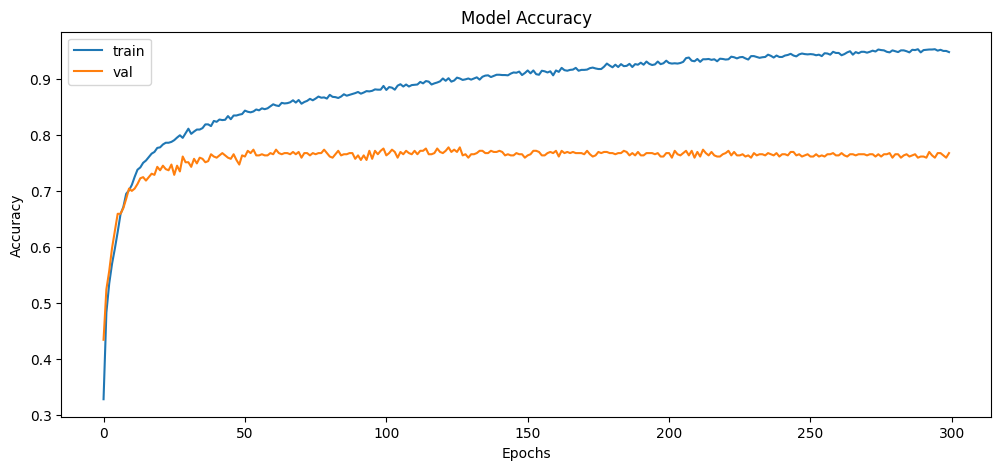

In [27]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

In [29]:
scores = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {scores[1] * 100}')
scores

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7883 - loss: 0.4935
Test Accuracy: 79.57516312599182


[0.5092335343360901, 0.7957516312599182]

In [30]:
y_pred = model.predict(x_test)

 3/20 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

W0000 00:00:1710252050.974857     270 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 785ms/step


W0000 00:00:1710252065.890146     270 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


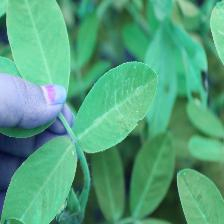

In [31]:
img = array_to_img(x_test[11])
img

In [32]:
print('original label: ', all_labels[np.argmax(y_test[11])])
print('predicted label: ', all_labels[np.argmax(y_pred[11])])
print(y_pred[2])
print((y_test).shape)

original label:  early_leaf_spot
predicted label:  early_leaf_spot
[7.5588244e-01 2.4851931e-02 2.1679348e-01 8.7380895e-06 2.4634073e-03]
(612, 5)


In [33]:
for i in range(0, len(y_test)):
    print(all_labels[np.argmax(y_test[i])], ' - ', all_labels[np.argmax(y_pred[i])])

late leaf spot  -  late leaf spot
healthy leaf  -  healthy leaf
early_leaf_spot  -  healthy leaf
healthy leaf  -  healthy leaf
healthy leaf  -  healthy leaf
early_leaf_spot  -  healthy leaf
healthy leaf  -  healthy leaf
early_leaf_spot  -  healthy leaf
late leaf spot  -  late leaf spot
early_leaf_spot  -  early_leaf_spot
healthy leaf  -  early_leaf_spot
early_leaf_spot  -  early_leaf_spot
late leaf spot  -  late leaf spot
late leaf spot  -  early_leaf_spot
rust  -  rust
late leaf spot  -  late leaf spot
early_leaf_spot  -  healthy leaf
early_leaf_spot  -  nutrition deficiency
early_leaf_spot  -  early_leaf_spot
late leaf spot  -  late leaf spot
healthy leaf  -  early_leaf_spot
late leaf spot  -  late leaf spot
late leaf spot  -  late leaf spot
early_leaf_spot  -  early_leaf_spot
nutrition deficiency  -  nutrition deficiency
early_leaf_spot  -  early_leaf_spot
early_leaf_spot  -  early_leaf_spot
late leaf spot  -  late leaf spot
late leaf spot  -  late leaf spot
late leaf spot  -  late 